<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

## Introduction

Predicting peaks in different markets is useful. In the electricity market, consuming electricity at peak demand is penalized with higher tarifs. When an individual or company consumes electricity when its most demanded, regulators calls that a coincident peak (CP).

In the Texas electricity market (ERCOT), the peak is the monthly 15-minute interval when the ERCOT Grid is at a point of highest capacity. The peak is caused by all consumers’ combined demand on the electrical grid. The coincident peak demand is an important factor used by ERCOT to determine final electricity consumption bills. ERCOT registers the CP demand of each client for 4 months, between June and September, and uses this to adjust electricity prices. Clients can therefore save on electricity bills by reducing the coincident peak demand.

In this example we will train an `MSTL` (Multiple Seasonal-Trend decomposition using LOESS) model on historic load data to forecast day-ahead peaks on September 2022. Multiple seasonality is traditionally present in low sampled electricity data. Demand exhibits daily and weekly seasonality, with clear patterns for specific hours of the day such as 6:00pm vs 3:00am or for specific days such as Sunday vs Friday.

First, we will load ERCOT historic demand, then we will use the `StatsForecast.cross_validation` method to fit the MSTL model and forecast daily load during September. Finally, we show how to use the forecasts to detect the coincident peak. 

**Outline**

1. Install libraries
1. Load and explore the data
1. Fit MSTL model and forecast
1. Peak detection

## Libraries

We assume you have StatsForecast already installed. Check this guide for instructions on [how to install StatsForecast](./Installation.ipynb).

Install the necessary packages using `pip install statsforecast`

## Load Data

The input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. 
We will rename the 

First, download and read the 2022 historic total demand of the ERCOT market, available [here](https://www.ercot.com/gridinfo/load/load_hist). The data processing includes adding the missing hour due to daylight saving time, parsing the date to datetime format, and filtering columns of interest. This step should take around 2s. 

In [ ]:
#|eval: false
import numpy as np
import pandas as pd

In [ ]:
#|eval: false
# Load data
historic = pd.read_csv('./Native_Load_2022.csv')
historic

,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2022 01:00,"12,054.94","1,302.30","4,161.19",757.84,"9,676.30","3,172.88","5,908.03",973.46,"38,006.94"
1,01/01/2022 02:00,"11,793.29","1,259.36","4,147.91",737.24,"9,307.13","3,123.32","5,708.51",959.78,"37,036.52"
2,01/01/2022 03:00,"11,460.84","1,210.29","4,156.41",725.61,"8,920.42","3,003.40","5,463.52",941.11,"35,881.61"
3,01/01/2022 04:00,"11,244.98","1,179.31","4,149.81",717.42,"8,678.81","2,898.10","5,255.25",920.37,"35,044.06"
4,01/01/2022 05:00,"11,073.09","1,171.84","4,140.62",719.18,"8,573.37","2,825.10","5,164.17",918.20,"34,585.57"
...,...,...,...,...,...,...,...,...,...,...
8755,12/31/2022 20:00,"10,247.56","1,407.68","5,219.00",938.90,"11,656.96","3,452.87","6,833.56","1,125.34","40,881.88"
8756,12/31/2022 21:00,"9,887.68","1,362.64","5,217.50",963.91,"11,242.91","3,228.13","6,629.00","1,103.92","39,635.70"
8757,12/31/2022 22:00,"9,572.38","1,327.30","5,235.31",949.80,"10,944.37","3,078.54","6,413.23","1,084.12","38,605.05"
8758,12/31/2022 23:00,"9,258.59","1,237.91","5,226.63",928.93,"10,508.05","3,020.18","6,161.41","1,058.60","37,400.30"


In [ ]:
#|eval: false
historic = historic.drop(8016)

In [ ]:
#|eval: false
historic['Hour Ending'][8015:8020]

8015    11/30/2022 24:00
8017    12/01/2022 02:00
8018    12/01/2022 03:00
8019    12/01/2022 04:00
8020    12/01/2022 05:00
Name: Hour Ending, dtype: object

In [ ]:
#|eval: false
# Add missing hour due to daylight saving time
historic = pd.concat([historic, pd.DataFrame({'Hour Ending':['03/13/2022 03:00'], 'ERCOT':['43980.57']})])
historic = historic.sort_values('Hour Ending').reset_index(drop=True)
# Convert to datetime
historic['ERCOT'] = historic['ERCOT'].str.replace(',','').astype(float)
historic = historic[~pd.isna(historic['ERCOT'])]
historic['ds'] = pd.to_datetime(historic['Hour Ending'].str[:10]) + pd.to_timedelta(np.tile(range(24), len(historic)//24),'h')
historic['unique_id'] = 'ERCOT'
historic['y'] = historic['ERCOT']
# Select relevant columns and dates
Y_df = historic[['unique_id', 'ds', 'y']]
Y_df = Y_df[Y_df['ds']<='2022-10-01']

Plot the series using the `plot` method from the `StatsForecast` class. This method prints up to 8 random series from the dataset and is useful for basic EDA.

:::{.callout-note}
The `StatsForecast.plot` method uses Plotly as a default engine. You can change to MatPlotLib by setting `engine="matplotlib"`. 
:::

/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


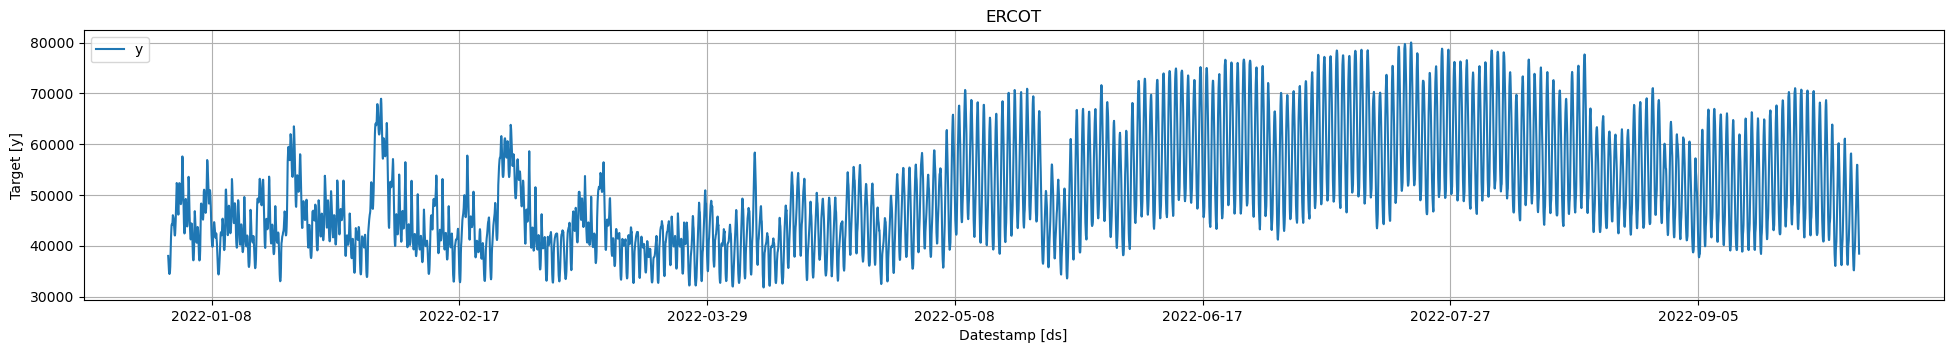

In [ ]:
#|eval: false
from statsforecast import StatsForecast

StatsForecast.plot(Y_df)

We observe that the time series exhibits seasonal patterns. Moreover, the time series contains `6,552` observations, so it is necessary to use computationally efficient methods to deploy them in production.

## Fit and Forecast MSTL model

The MSTL (Multiple Seasonal-Trend decomposition using LOESS) model decomposes the time series in multiple seasonalities using a Local Polynomial Regression (LOESS). Then it forecasts the trend using a custom non-seasonal model and each seasonality using a SeasonalNaive model.

:::{.callout-tip}
Check our detailed explanation and tutorial on MSTL [here](https://nixtla.github.io/statsforecast/examples/multipleseasonalities.html)
:::

Import the `StatsForecast` class and the models you need. 

In [ ]:
#|eval: false
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA

First, instantiate the model and define the parameters. The electricity load presents seasonalities every 24 hours (Hourly) and every 24 * 7 (Daily) hours. Therefore, we will use `[24, 24 * 7]` as the seasonalities. See [this link](https://robjhyndman.com/hyndsight/seasonal-periods/) for a detailed explanation on how to set seasonal lengths. In this example we use the `AutoARIMA` model for the trend component, however, any StatsForecast model can be used. The complete list of models is available [here](https://nixtla.github.io/statsforecast/models.html).

In [ ]:
#|eval: false
models = [MSTL(
            season_length=[24, 24 * 7], # seasonalities of the time series 
            trend_forecaster=AutoARIMA(nmodels=10) # model used to forecast trend
            )
          ]

:::{.callout-tip}
The parameter `nmodels` of the AutoARIMA controls the number of models considered in stepwise search. The default is 94, reduce it to decrease training times!
:::

We fit the model by instantiating a `StatsForecast` object with the following required parameters:

* `models`: a list of models. Select the models you want from [models](../models.ipynb) and import them.

* `freq`: a string indicating the frequency of the data. (See [panda's available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

In [ ]:
#|eval: false
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=Y_df, 
    models=models,
    freq='H', 
)

:::{.callout-tip}
StatsForecast also supports this optional parameter.

* `n_jobs`: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores. (Default: 1)

* `fallback_model`: a model to be used if a model fails. (Default: none)

:::

The `cross_validation` method allows the user to simulate multiple historic forecasts, greatly simplifying pipelines by replacing for loops with `fit` and `predict` methods. This method re-trains the model and forecast each window. See [this tutorial](https://nixtla.github.io/statsforecast/examples/getting_started_complete.html) for an animation of how the windows are defined. 

Use the `cross_validation` method to produce all the daily forecasts for September. To produce daily forecasts set the forecasting horizon `h` as 24. In this example we are simulating deploying the pipeline during September, so set the number of windows as 30 (one for each day). Finally, set the step size between windows as 24, to only produce one forecast per day.

In [ ]:
#|eval: false
crossvalidation_df = sf.cross_validation(
    df=Y_df,
    h=24,
    step_size=24,
    n_windows=30
  )

/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/statsforecast/arima.py:2270: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=10
  warnings.warn(
/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/statsforecast/arima.py:2270: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=10
  warnings.warn(
/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/statsforecast/arima.py:2270: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=10
  warnings.warn(
/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/statsforecast/arima.py:2270: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=10
  warnings.warn(
/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/statsforecast/arima.py:2270: UserWarning: Stepwise search was stopped early due to reaching the mod

In [ ]:
#|eval: false
crossvalidation_df.head()

,ds,cutoff,y,MSTL
unique_id,,,,
ERCOT,2022-09-01 01:00:00,2022-09-01,43602.660156,44841.687500
ERCOT,2022-09-01 02:00:00,2022-09-01,42284.820312,43591.015625
ERCOT,2022-09-01 03:00:00,2022-09-01,41663.160156,42850.105469
ERCOT,2022-09-01 04:00:00,2022-09-01,41710.621094,43010.621094
ERCOT,2022-09-01 05:00:00,2022-09-01,42847.570312,44453.636719


:::{.callout-important}
When using `cross_validation` make sure the forecasts are produced at the desired timestamps. Check the `cutoff` column which specifices the last timestamp before the forecasting window.
:::

## Peak Detection

Finally, we use the forecasts in `crossvaldation_df` to detect the daily hourly demand peaks. For each day, we set the detected peaks as the highest forecasts. In this case, we want to predict one peak (`npeaks`); depending on your setting and goals, this parameter might change. For example, the number of peaks can correspond to how many hours a battery can be discharged to reduce demand.

In [ ]:
#|eval: false
npeaks = 1 # Number of peaks

For the ERCOT 4CP detection task we are interested in correctly predicting the highest monthly load. Next, we filter the day in September with the highest hourly demand and predict the peak.

In [ ]:
#|eval: false
crossvalidation_df = crossvalidation_df.reset_index()[['ds','y','MSTL']]
max_day = crossvalidation_df.iloc[crossvalidation_df['y'].argmax()].ds.day # Day with maximum load
cv_df_day = crossvalidation_df.query('ds.dt.day == @max_day')
max_hour = cv_df_day['y'].argmax()
peaks = cv_df_day['MSTL'].argsort().iloc[-npeaks:].values # Predicted peaks

In the following plot we see how the MSTL model is able to correctly detect the coincident peak for September 2022.

In [ ]:
#|eval: false
import matplotlib.pyplot as plt

<matplotlib.legend.Legend>

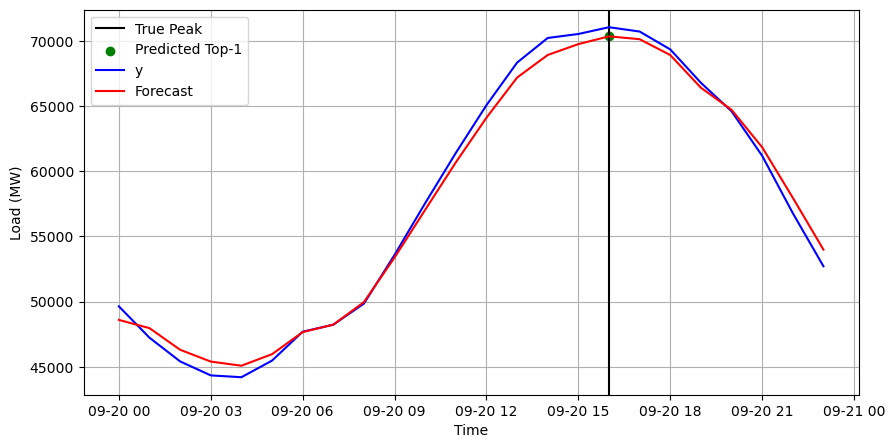

In [ ]:
#|eval: false
plt.figure(figsize=(10, 5))
plt.axvline(cv_df_day.iloc[max_hour]['ds'], color='black', label='True Peak')
plt.scatter(cv_df_day.iloc[peaks]['ds'], cv_df_day.iloc[peaks]['MSTL'], color='green', label=f'Predicted Top-{npeaks}')
plt.plot(cv_df_day['ds'], cv_df_day['y'], label='y', color='blue')
plt.plot(cv_df_day['ds'], cv_df_day['MSTL'], label='Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Load (MW)')
plt.grid()
plt.legend()

:::{.callout-important}
In this example we only include September. However, MSTL can correctly predict the peaks for the 4 months of 2022. You can try this by increasing the `nwindows` parameter of `cross_validation` or filtering the `Y_df` dataset. The complete run for all months take only 10 minutes.
:::

## Next steps

StatsForecast and MSTL in particular are good benchmarking models for peak detection. However, it might be useful to explore further and newer forecasting algorithms. We have seen particularly good results with the N-HiTS, a deep-learning model from Nixtla's NeuralForecast library.

Learn how to predict ERCOT demand peaks with our deep-learning N-HiTS model and the NeuralForecast library in [this tutorial](https://nixtla.github.io/neuralforecast/examples/electricitypeakforecasting.html).

## References

- [Bandara, Kasun & Hyndman, Rob & Bergmeir, Christoph. (2021). “MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple Seasonal Patterns”](https://arxiv.org/abs/2107.13462).
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting". Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)